In [1]:
import torch

# Import the required functions for simulation-based inference (SBI)
from sbi.analysis import pairplot  # For visualizing posterior samples as pair plots
from sbi.inference import NPE  # Neural Posterior Estimation algorithm
from sbi.utils import BoxUniform  # Uniform prior for parameters
from sbi.utils.user_input_checks import (
    check_sbi_inputs,  # Verify the simulator and prior are compatible
    process_prior,     # Process the given prior to ensure it's in the right format
    process_simulator, # Prepare the simulator so it can handle batched inputs
)


/Users/micahtilton/miniconda3/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the number of dimensions (parameters) in the simulator and prior
num_dim = 3

def simulator(theta):
    """
    A simple linear Gaussian simulator.
    
    It takes an input parameter tensor theta, shifts it by 1.0, 
    and adds Gaussian noise (with a standard deviation of 0.1) to each element.
    """
    # theta + 1.0: deterministic shift
    # torch.randn_like(theta) * 0.1: adds Gaussian noise with std=0.1
    return theta + 1.0 + torch.randn_like(theta) * 0.1

# Define a uniform prior for our parameters with bounds [-2, 2] in each dimension.
prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

In [3]:
# Process the prior to ensure it is compatible with the SBI toolbox;
# this function returns the PyTorch-format prior, the number of parameters,
# and a flag indicating whether the prior returns numpy arrays.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Similarly, process the simulator so that it accepts batches of parameters
# and returns PyTorch tensors.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Check that the simulator and prior are set up correctly for SBI.
check_sbi_inputs(simulator, prior)

In [4]:
# Initialize the Neural Posterior Estimation (NPE) inference object with the processed prior.
inference = NPE(prior=prior)

In [5]:
# Set the number of simulations (i.e., simulated data points to generate)
num_simulations = 2000

# Sample parameters (theta) from the prior.
# The resulting shape is (num_simulations, num_dim).
theta = prior.sample((num_simulations,))

# Run the simulator on the generated parameters to produce observations (x).
x = simulator(theta)

# Print out the shapes of theta and x for confirmation.
print("theta.shape", theta.shape)
print("x.shape", x.shape)

theta.shape torch.Size([2000, 3])
x.shape torch.Size([2000, 3])


In [6]:
# Append the (theta, x) simulation pairs to the inference object for training.
inference = inference.append_simulations(theta, x)

In [7]:
# Train the density estimator (neural network) on the simulation data.
density_estimator = inference.train()

 Neural network successfully converged after 85 epochs.

In [8]:
# Build the posterior over parameters using the trained density estimator.
posterior = inference.build_posterior(density_estimator)

# Print information on the trained posterior.
print(posterior)  # Displays how the posterior was trained and its properties

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [9]:
# Sample a "true" parameter from the prior.
theta_true = prior.sample((1,))

# Generate the corresponding "observed" data by running the simulator on theta_true.
x_obs = simulator(theta_true)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 186758.81it/s]


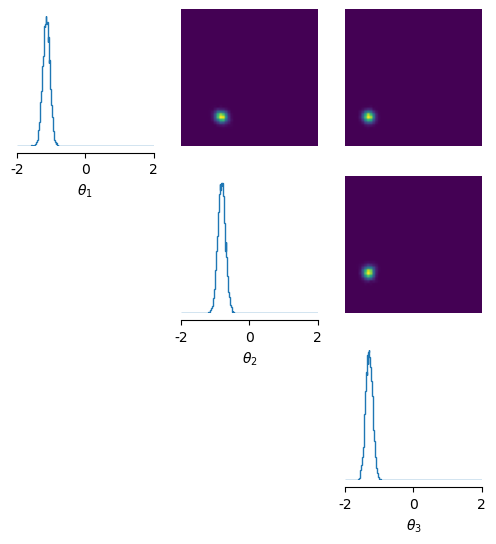

In [10]:
# Sample 10,000 parameter values from the posterior conditioned on the observation x_obs.
samples = posterior.sample((10000,), x=x_obs)

# Plot a pairplot of the posterior samples (without overlaying any true parameter).
_ = pairplot(
    samples,
    limits=[[-2, 2], [-2, 2], [-2, 2]],
    figsize=(6, 6),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]
)

Drawing 10000 posterior samples: 10280it [00:00, 154649.79it/s]           


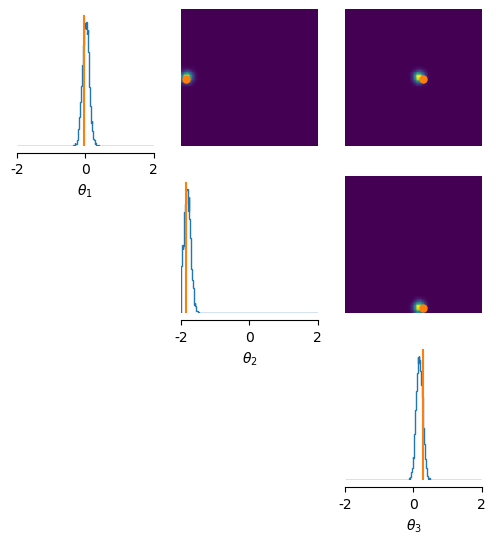

In [ ]:
# Sample again from the posterior.
samples = posterior.sample((10000,), x=x_obs)

# Plot a pairplot of the sampled parameters, now overlaying the true parameter value.
pairplot(
    samples,
    points=theta_true,  # Overlay true parameter for reference
    limits=[[-2, 2], [-2, 2], [-2, 2]],
    figsize=(6, 6),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]
)

Drawing 10000 posterior samples: 10250it [00:00, 154990.65it/s]           


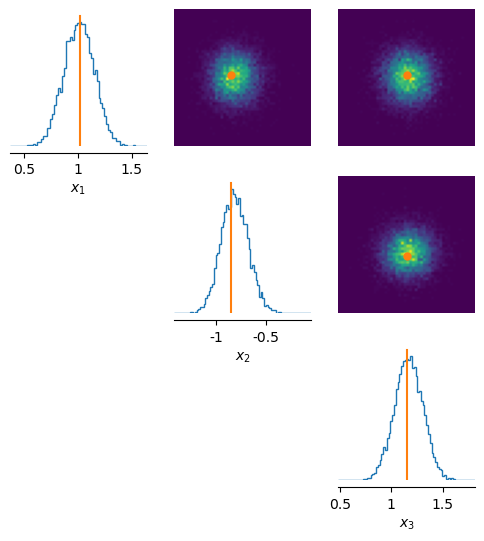

In [ ]:
# Draw 10,000 samples from the posterior for generating predictive data.
theta_posterior = posterior.sample((10000,), x=x_obs)  # Posterior samples

# Simulate predictive observations from the posterior parameter samples.
x_predictive = simulator(theta_posterior)

# Plot a pairplot of the predictive observations, overlaying the observed data x_obs.
pairplot(
    x_predictive,
    points=x_obs,  # Point to compare the simulated data with the observation
    figsize=(6, 6),
    labels=[r"$x_1$", r"$x_2$", r"$x_3$"]
)

In [ ]:
# Sample an alternative parameter (theta_diff) from the prior.
theta_diff = prior.sample((1,))

In [ ]:
# Compute the log probability of the true parameter under the posterior given x_obs.
log_probability_true_theta = posterior.log_prob(theta_true, x=x_obs)

# Compute the log probability of the alternative parameter under the posterior.
log_probability_diff_theta = posterior.log_prob(theta_diff, x=x_obs)

# Compute the log probabilities for all the sampled posterior parameters.
log_probability_samples = posterior.log_prob(samples, x=x_obs)

# Print the log probabilities to compare:
print(r'high for true theta :', log_probability_true_theta)
print(r'low for different theta :', log_probability_diff_theta)
print(
    r'range of posterior samples: min:',
    torch.min(log_probability_samples),
    ' max :',
    torch.max(log_probability_samples)
)

high for true theta : tensor([3.5727])
low for different theta : tensor([-141.4484])
range of posterior samples: min: tensor(-7.1738)  max : tensor(4.2482)
